# Cross-country model for predicting scaled, relative wealth index
This notebook is for re-producing the final model used to estimate wealth for the countries with no DHS ground truth.

We combine data from 4 countries where we have DHS ground truth (KH, MM, PH, TL) and train one combined model from all these data. 
The features and wealth indices are scaled per country to make them comparable. 

The output model is a Random Forest regressor trained on scaled labels (DHS Wealth Index) and features (area statistics for OSM, Ookla, and nighttime lights).

We will not do evaluation in this notebook as we have estimated the performance already through leave-one-out cross-validation procedure in a different notebook (please refer to our doc site).


In [23]:
import sys
sys.path.append("../../")

import os

import uuid
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely import wkt

from povertymapping import settings, nightlights
from povertymapping.dhs import generate_dhs_cluster_level_data
from povertymapping.feature_engineering import *
import getpass
import pickle

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

import shap

In [24]:
%reload_ext autoreload
%autoreload 2

# Set up Data Access for EOG (Nighttime lights)
The following cell will prompt you to enter your EOG username and password. See [this page](https://eogdata.mines.edu/products/register/) to learn how to set-up your EOG account.

In [25]:
# Log-in using EOG credentials
username = os.environ.get('EOG_USER',None)
username = username if username is not None else input('Username?')
password = os.environ.get('EOG_PASSWORD',None)
password = password if password is not None else getpass.getpass('Password?') 

# set save_token to True so that access token gets stored in ~/.eog_creds/eog_access_token
access_token = nightlights.get_eog_access_token(username,password, save_token=True)

2023-03-07 18:46:05.195 | INFO     | povertymapping.nightlights:get_eog_access_token:48 - Saving access_token to ~/.eog_creds/eog_access_token
2023-03-07 18:46:05.196 | INFO     | povertymapping.nightlights:get_eog_access_token:56 - Adding access token to environmentt var EOG_ACCESS_TOKEN


# Generate training data from the combined 4 countries' data

We normalized each model feature by country to correct country-specific feature quirks, as well as the wealth index.

This method has been done in a [similar study](https://doi.org/10.1073/pnas.2113658119) using DHS as training data and was also documented [here](https://www.dhsprogram.com/pubs/pdf/MR9/MR9.pdf).

Models recover how relative values of input data (relative to other locations in that country) correlate with relative values of wealth (also relative to other locations in that country).

The current best model setup involves (1) normalizing all features per country using `StandardScaler` and (2) scaling the wealth index per country using `StandardScaler`

If this is your first time running this notebook for this specific area, expect a long runtime for the following cell as it will download and cache the required datasets. It will then process the relevant features for each area specified. On subsequent runs, the runtime will be much faster as the data is already stored in your filesystem. 


## Data config per country

In [26]:
# Set country-specific variables
country_config = {
    'Philippines': {
        'country_osm':'philippines',
        'ookla_year': 2019,
        'nightlights_year' : 2017,
        'country_code': 'ph',
        'dhs_household_dta_path' : settings.DATA_DIR/"dhs/ph/PHHR71DT/PHHR71FL.DTA",
        'dhs_geographic_shp_path' : settings.DATA_DIR/"dhs/ph/PHGE71FL/PHGE71FL.shp"
    },
    'Timor Leste': {
        'country_osm':'east-timor',
        'ookla_year': 2019,
        'nightlights_year' : 2016,
        'country_code': 'tl',
        'dhs_household_dta_path' : settings.DATA_DIR/"dhs/tl/TLHR71DT/TLHR71FL.DTA",
        'dhs_geographic_shp_path' : settings.DATA_DIR/"dhs/tl/TLGE71FL/TLGE71FL.shp"
    },
    'Cambodia': {
        'country_osm':'cambodia',
        'ookla_year': 2019,
        'nightlights_year' : 2014,
        'country_code': 'kh',
        'dhs_household_dta_path' : settings.DATA_DIR/"dhs/kh/KHHR73DT/KHHR73FL.DTA",
        'dhs_geographic_shp_path' : settings.DATA_DIR/"dhs/kh/KHGE71FL/KHGE71FL.shp"
    },
    'Myanmar': {
        'country_osm':'myanmar',
        'ookla_year': 2019,
        'nightlights_year' : 2015,
        'country_code': 'mm',
        'dhs_household_dta_path' : settings.DATA_DIR/"dhs/mm/MMHR71DT/MMHR71FL.DTA",
        'dhs_geographic_shp_path' : settings.DATA_DIR/"dhs/mm/MMGE71FL/MMGE71FL.shp"
    }
}

## Generate scaled features + labels per country, then combine

In [27]:
%%time

# Create list of dataframes per country, and list of all columns appearing in DHS columns
country_data_list = []

for country, config in country_config.items():
    print(f'Loading data for {country}')

    # Load the DHS cluster data
    dhs_gdf = generate_dhs_cluster_level_data(
        config['dhs_household_dta_path'], 
        config['dhs_geographic_shp_path'], 
        col_rename_config= config['country_code'],
        convert_geoms_to_bbox=True,
        bbox_size_km = 2.4
    ).reset_index(drop=True)

    # Create labels array by scaling the specified label_col (ex. Wealth Index)
    # Need to extract this before generating features because we'll be dropping the non-feature columns
    labels = StandardScaler().fit_transform(dhs_gdf[["Wealth Index"]])

    # Generate features
    features = generate_features(dhs_gdf,config['country_osm'],\
                                     config['ookla_year'],config['nightlights_year'], sklearn_scaler=StandardScaler,\
                                     scaled_only=True, features_only=True)

    # Create combined GDF containing features and the label
    country_data = features.copy()
    country_data['label'] = labels
    
    country_data_list.append(country_data)

# Combine all country data into a single dataframe
countries_data = gpd.GeoDataFrame(pd.concat(country_data_list,ignore_index=True), crs=country_data_list[0].crs)


# Split the GDF back into features and labels for training
feature_cols = [col for col in countries_data.columns if col != 'label']
features = countries_data[feature_cols]
labels = countries_data['label']

Loading data for Philippines


2023-03-07 18:46:13.463 | INFO     | povertymapping.osm:download_osm_country_data:187 - OSM Data: Cached data available for philippines at /home/alron/.geowrangler/osm/philippines? True
2023-03-07 18:46:13.464 | DEBUG    | povertymapping.osm:load_pois:149 - OSM POIs for philippines being loaded from /home/alron/.geowrangler/osm/philippines/gis_osm_pois_free_1.shp
2023-03-07 18:46:18.889 | INFO     | povertymapping.osm:download_osm_country_data:187 - OSM Data: Cached data available for philippines at /home/alron/.geowrangler/osm/philippines? True
2023-03-07 18:46:18.890 | DEBUG    | povertymapping.osm:load_roads:168 - OSM Roads for philippines being loaded from /home/alron/.geowrangler/osm/philippines/gis_osm_roads_free_1.shp
2023-03-07 18:47:02.350 | DEBUG    | povertymapping.ookla:load_type_year_data:68 - Contents of data cache: []
2023-03-07 18:47:02.351 | INFO     | povertymapping.ookla:load_type_year_data:83 - Cached data available at /home/alron/.geowrangler/ookla/processed/2f858b

Loading data for Timor Leste


2023-03-07 18:47:14.260 | INFO     | povertymapping.osm:download_osm_country_data:187 - OSM Data: Cached data available for east-timor at /home/alron/.geowrangler/osm/east-timor? True
2023-03-07 18:47:14.261 | DEBUG    | povertymapping.osm:load_pois:149 - OSM POIs for east-timor being loaded from /home/alron/.geowrangler/osm/east-timor/gis_osm_pois_free_1.shp
2023-03-07 18:47:15.490 | INFO     | povertymapping.osm:download_osm_country_data:187 - OSM Data: Cached data available for east-timor at /home/alron/.geowrangler/osm/east-timor? True
2023-03-07 18:47:15.491 | DEBUG    | povertymapping.osm:load_roads:168 - OSM Roads for east-timor being loaded from /home/alron/.geowrangler/osm/east-timor/gis_osm_roads_free_1.shp
2023-03-07 18:47:16.003 | DEBUG    | povertymapping.ookla:load_type_year_data:68 - Contents of data cache: []
2023-03-07 18:47:16.004 | INFO     | povertymapping.ookla:load_type_year_data:83 - Cached data available at /home/alron/.geowrangler/ookla/processed/206a0323fa0e80

Loading data for Cambodia


2023-03-07 18:47:20.078 | INFO     | povertymapping.osm:download_osm_country_data:187 - OSM Data: Cached data available for cambodia at /home/alron/.geowrangler/osm/cambodia? True
2023-03-07 18:47:20.079 | DEBUG    | povertymapping.osm:load_pois:149 - OSM POIs for cambodia being loaded from /home/alron/.geowrangler/osm/cambodia/gis_osm_pois_free_1.shp
2023-03-07 18:47:21.858 | INFO     | povertymapping.osm:download_osm_country_data:187 - OSM Data: Cached data available for cambodia at /home/alron/.geowrangler/osm/cambodia? True
2023-03-07 18:47:21.859 | DEBUG    | povertymapping.osm:load_roads:168 - OSM Roads for cambodia being loaded from /home/alron/.geowrangler/osm/cambodia/gis_osm_roads_free_1.shp
2023-03-07 18:47:26.826 | DEBUG    | povertymapping.ookla:load_type_year_data:68 - Contents of data cache: []
2023-03-07 18:47:26.827 | INFO     | povertymapping.ookla:load_type_year_data:83 - Cached data available at /home/alron/.geowrangler/ookla/processed/37f570ebc130cb44f9dba877fbda74

Loading data for Myanmar


2023-03-07 18:47:32.346 | INFO     | povertymapping.osm:download_osm_country_data:187 - OSM Data: Cached data available for myanmar at /home/alron/.geowrangler/osm/myanmar? True
2023-03-07 18:47:32.346 | DEBUG    | povertymapping.osm:load_pois:149 - OSM POIs for myanmar being loaded from /home/alron/.geowrangler/osm/myanmar/gis_osm_pois_free_1.shp
2023-03-07 18:47:34.562 | INFO     | povertymapping.osm:download_osm_country_data:187 - OSM Data: Cached data available for myanmar at /home/alron/.geowrangler/osm/myanmar? True
2023-03-07 18:47:34.563 | DEBUG    | povertymapping.osm:load_roads:168 - OSM Roads for myanmar being loaded from /home/alron/.geowrangler/osm/myanmar/gis_osm_roads_free_1.shp
2023-03-07 18:47:48.987 | DEBUG    | povertymapping.ookla:load_type_year_data:68 - Contents of data cache: []
2023-03-07 18:47:48.988 | INFO     | povertymapping.ookla:load_type_year_data:83 - Cached data available at /home/alron/.geowrangler/ookla/processed/d72ec7e4d144b750e1c0950ecad081e0.csv? 

CPU times: user 1min 43s, sys: 1.7 s, total: 1min 45s
Wall time: 1min 45s


## Inspect the combined data

In [28]:
countries_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2720 entries, 0 to 2719
Data columns (total 62 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   poi_count_scaled                          2720 non-null   float64
 1   atm_count_scaled                          2720 non-null   float64
 2   atm_nearest_scaled                        2720 non-null   float64
 3   bank_count_scaled                         2720 non-null   float64
 4   bank_nearest_scaled                       2720 non-null   float64
 5   bus_station_count_scaled                  2720 non-null   float64
 6   bus_station_nearest_scaled                2720 non-null   float64
 7   cafe_count_scaled                         2720 non-null   float64
 8   cafe_nearest_scaled                       2720 non-null   float64
 9   charging_station_count_scaled             2720 non-null   float64
 10  charging_station_nearest_sca

In [29]:
countries_data.head()

,poi_count_scaled,atm_count_scaled,atm_nearest_scaled,bank_count_scaled,bank_nearest_scaled,bus_station_count_scaled,bus_station_nearest_scaled,cafe_count_scaled,cafe_nearest_scaled,charging_station_count_scaled,...,mobile_2019_mean_avg_u_kbps_mean_scaled,mobile_2019_mean_avg_lat_ms_mean_scaled,mobile_2019_mean_num_tests_mean_scaled,mobile_2019_mean_num_devices_mean_scaled,avg_rad_min_scaled,avg_rad_max_scaled,avg_rad_mean_scaled,avg_rad_std_scaled,avg_rad_median_scaled,label
0,-0.385350,-0.304109,0.981691,-0.311688,-0.584550,0.0,0.0,-0.279062,1.084317,0.0,...,-0.242961,-0.992909,-0.47001,-0.457159,-0.385826,-0.489671,-0.457635,-0.500904,-0.441133,-0.518348
1,-0.348973,-0.304109,0.981691,-0.228042,-1.121302,0.0,0.0,-0.279062,1.084317,0.0,...,0.351612,0.218633,-0.34380,-0.318012,-0.379433,-0.105420,-0.338843,0.022298,-0.420192,-0.109205
2,-0.385350,-0.304109,0.981691,-0.311688,-0.074588,0.0,0.0,-0.279062,1.084317,0.0,...,2.805360,0.278827,-0.42576,-0.406261,-0.386158,-0.456857,-0.448578,-0.461950,-0.438102,-0.881529
3,-0.385350,-0.304109,0.981691,-0.311688,1.271359,0.0,0.0,-0.279062,1.084317,0.0,...,0.000000,0.000000,0.00000,0.000000,-0.390065,-0.491952,-0.460721,-0.501857,-0.444831,-0.843550
4,-0.385350,-0.304109,0.690833,-0.311688,0.975300,0.0,0.0,-0.279062,1.084317,0.0,...,0.000000,0.000000,0.00000,0.000000,-0.384759,-0.490766,-0.458338,-0.503296,-0.442691,-1.206499


In [30]:
features.head()

,poi_count_scaled,atm_count_scaled,atm_nearest_scaled,bank_count_scaled,bank_nearest_scaled,bus_station_count_scaled,bus_station_nearest_scaled,cafe_count_scaled,cafe_nearest_scaled,charging_station_count_scaled,...,mobile_2019_mean_avg_d_kbps_mean_scaled,mobile_2019_mean_avg_u_kbps_mean_scaled,mobile_2019_mean_avg_lat_ms_mean_scaled,mobile_2019_mean_num_tests_mean_scaled,mobile_2019_mean_num_devices_mean_scaled,avg_rad_min_scaled,avg_rad_max_scaled,avg_rad_mean_scaled,avg_rad_std_scaled,avg_rad_median_scaled
0,-0.385350,-0.304109,0.981691,-0.311688,-0.584550,0.0,0.0,-0.279062,1.084317,0.0,...,-0.895259,-0.242961,-0.992909,-0.47001,-0.457159,-0.385826,-0.489671,-0.457635,-0.500904,-0.441133
1,-0.348973,-0.304109,0.981691,-0.228042,-1.121302,0.0,0.0,-0.279062,1.084317,0.0,...,-0.677345,0.351612,0.218633,-0.34380,-0.318012,-0.379433,-0.105420,-0.338843,0.022298,-0.420192
2,-0.385350,-0.304109,0.981691,-0.311688,-0.074588,0.0,0.0,-0.279062,1.084317,0.0,...,1.078235,2.805360,0.278827,-0.42576,-0.406261,-0.386158,-0.456857,-0.448578,-0.461950,-0.438102
3,-0.385350,-0.304109,0.981691,-0.311688,1.271359,0.0,0.0,-0.279062,1.084317,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,-0.390065,-0.491952,-0.460721,-0.501857,-0.444831
4,-0.385350,-0.304109,0.690833,-0.311688,0.975300,0.0,0.0,-0.279062,1.084317,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,-0.384759,-0.490766,-0.458338,-0.503296,-0.442691


In [31]:
labels.head()

0   -0.518348
1   -0.109205
2   -0.881529
3   -0.843550
4   -1.206499
Name: label, dtype: float64

<AxesSubplot: >

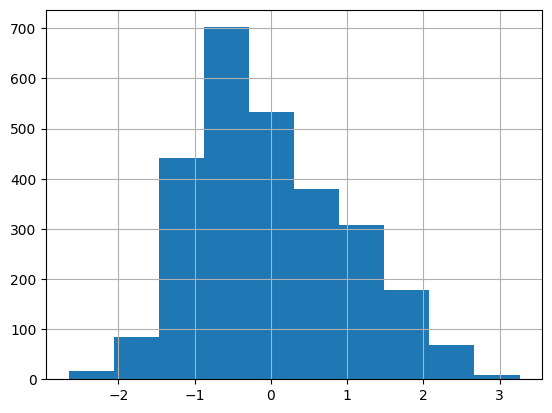

In [32]:
labels.hist()

# Model Training


For training the final model, we train on all the available data.

As mentioned above, we will not do evaluation in this notebook  as we have estimated this methodology's performance already through leave-one-country-out cross-validation procedure in a different notebook (please refer to our [doc site](https://thinkingmachines.github.io/unicef-ai4d-poverty-mapping/cross-country-report.html)).



In [33]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42, verbose=0)
model

RandomForestRegressor(random_state=42)

In [34]:
model.fit(features.values, labels.values.ravel())

RandomForestRegressor(random_state=42)

### SHAP Feature Importance

In [35]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features)

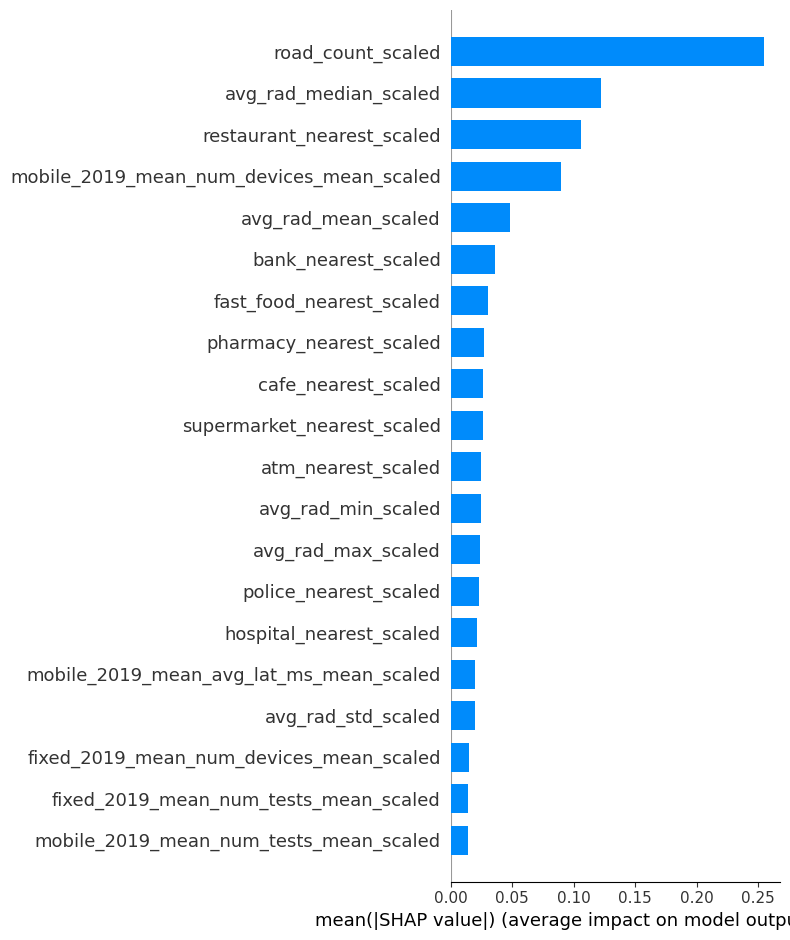

In [36]:
shap.summary_plot(shap_values, features, feature_names=features.columns, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


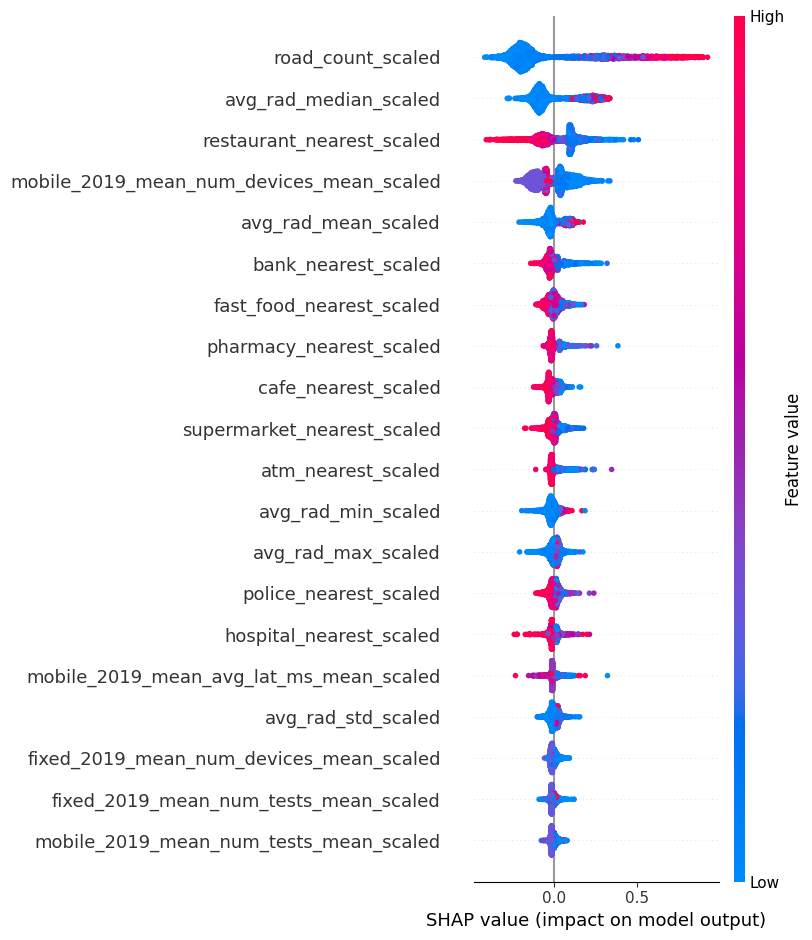

In [37]:
shap.summary_plot(shap_values, features.values, feature_names=features.columns)

## Save Model

In [38]:
current_date = pd.to_datetime("today").strftime("%Y-%m-%d")
model_save_path = f'./{current_date}-cross-country-model.pkl'
with open(model_save_path, "wb") as file:
    pickle.dump(model, file)